# ROMS in Python - Analyses: KmKe and PeKe

by David Gwyther

This notebook will focus on KmKe and PeKe analyses

In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/tmp'

In [3]:
# cartopy load the coast:

import cartopy.feature as cfeature

def loadCartopyCoast():
    Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',
                                    facecolor='none', name='coastline')
    return Coast

Coast = loadCartopyCoast()


In [4]:
# from dask.distributed import Client,Scheduler
# from dask_jobqueue import SLURMCluster
# cluster = SLURMCluster(cores=16,processes=1,memory="47GB")
# client = Client(cluster)
# cluster.scale(cores=48)
# print(client)

## load data

In [6]:
# load multiple ROMS netcdf with xr


filelist = glob.glob('../data/raw/outer_his_0800*.nc')
chunks = chunks={'ocean_time':1}
def RemoveSomeDays(ds):
    '''remove the last 7 timesteps from each file'''
    return ds.isel(ocean_time = slice(0,-7))

ds = xr.open_mfdataset(filelist,chunks, preprocess=RemoveSomeDays, data_vars='minimal', compat='override', coords='minimal', parallel=False, join='right')
ds

# # note that I turned off parallel - was finding it was freezing with dask?
# # alternative: load once, chop off vars and save to a processed netcdf, then load with:

# ds = xr.open_dataset('/g/data/fu5/deg581/OSSE_analysis/data/proc/output_truth_8005_8401.nc')
# ds

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 317,
                    xi_rho: 272, eta_u: 317, xi_u: 271, eta_v: 316, xi_v: 272,
                    eta_psi: 316, xi_psi: 271, ocean_time: 72)
Coordinates:
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lon_u          (eta_u, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lat_u          (eta_u, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lon_v          (eta_v, xi_v) float64 dask.array<chunksize=(316, 272), meta=np.ndarray>
    lat_v          (eta_v, xi_v) float64 dask.array<chunksize=(316, 272), meta=np.ndarray>
    lon_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
    lat_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2011-11-28 ... 2011-12-09T20:0...
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/90)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    shflux         (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 317, 272), meta=np.ndarray>
    ssflux         (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 317, 272), meta=np.ndarray>
    sustr          (ocean_time, eta_u, xi_u) float32 dask.array<chunksize=(1, 317, 271), meta=np.ndarray>
    svstr          (ocean_time, eta_v, xi_v) float32 dask.array<chunksize=(1, 316, 272), meta=np.ndarray>
    bustr          (ocean_time, eta_u, xi_u) float32 dask.array<chunksize=(1, 317, 271), meta=np.ndarray>
    bvstr          (ocean_time, eta_v, xi_v) float32 dask.array<chunksize=(1, 316, 272), meta=np.ndarray>
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

## let's first process our dataset and make a grid file

In [8]:
# do special processing for ROMS formatting


def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds



def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut

ds = processROMSGrid(ds)

grid = makeROMSGridObject(ds)

In [9]:
ds

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 317,
                    xi_rho: 272, xi_u: 271, eta_v: 316, ocean_time: 72)
Coordinates: (12/14)
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lon_u          (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lat_u          (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    ...             ...
    lon_psi        (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
    lat_psi        (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2011-11-28 ... 2011-12-09T20:0...
    z_w            (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 317, 272), meta=np.ndarray>
    z_rho          (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 30, 317, 272), meta=np.ndarray>
    z_rho0         (eta_rho, xi_rho, s_rho) float64 dask.array<chunksize=(317, 272, 30), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/113)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    dz_w           (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 317, 272), meta=np.ndarray>
    dz_u           (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 30, 317, 271), meta=np.ndarray>
    dz_w_u         (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 31, 317, 271), meta=np.ndarray>
    dz_v           (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 30, 316, 272), meta=np.ndarray>
    dz_w_v         (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 31, 316, 272), meta=np.ndarray>
    dA             (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

In [8]:
# drop some variables to speed up loading!
ds = ds[['u','v','w','dz','dx','dy','temp','salt']]
# ds = ds.drop('z_rho')

# Let's load the u,v velocities to speed this up...
ds.load()


<xarray.Dataset>
Dimensions:     (ocean_time: 80, s_rho: 30, eta_rho: 317, xi_u: 271, eta_v: 316, xi_rho: 272, s_w: 31)
Coordinates: (12/14)
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w         (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
    lon_u       (eta_rho, xi_u) float64 147.1 147.1 147.2 ... 162.1 162.1 162.2
    lat_u       (eta_rho, xi_u) float64 -38.5 -38.51 -38.52 ... -28.14 -28.15
    ...          ...
    lon_psi     (eta_v, xi_u) float64 147.1 147.2 147.2 ... 162.1 162.1 162.2
    lat_psi     (eta_v, xi_u) float64 -38.48 -38.49 -38.5 ... -28.16 -28.18
  * ocean_time  (ocean_time) datetime64[ns] 2011-12-02 2011-12-07 ... 2012-12-31
    z_w         (ocean_time, s_w, eta_rho, xi_rho) float64 0.0 0.0 ... 0.4941
    z_rho       (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... -1.028
    z_rho0      (eta_rho, xi_rho, s_rho) float64 nan nan nan ... -4.483 -1.035
Dimensions without coordinates: eta_rho, xi_u, eta_v, xi_rho
Data variables:
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 nan nan ... -0.3036
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 nan nan ... -0.03968
    w           (ocean_time, s_w, eta_rho, xi_rho) float64 nan nan ... 4.794e-07
    dz          (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... 3.178
    dx          (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03 6e+03
    dy          (eta_rho, xi_rho) float64 5e+03 4.999e+03 ... 4.881e+03
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 23.66
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 nan nan ... 35.74
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

## calculate KmKe


In [10]:
def calc_KmKe(input):

    u = input.u
    v = input.v

    u_bar = u.mean("ocean_time")
    v_bar = v.mean("ocean_time")

    # input.u_bar.attrs["grid"] = grid
    # input.v_bar.attrs["grid"] = grid

    # mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u - u_bar
    v_prime = v - v_bar

    u_bar_rho=grid.interp(u_bar,axis="X",boundary="fill")
    v_bar_rho=grid.interp(v_bar,axis="Y",boundary="fill")

    u_prime_rho=grid.interp(u_prime,axis="X",boundary="fill")
    v_prime_rho=grid.interp(v_prime,axis="Y",boundary="fill")
    
    dudx = grid.derivative(u_bar,'X',boundary='fill')
    dudy = grid.derivative(u_bar_rho,'Y',boundary='fill')
    dvdx = grid.derivative(v_bar_rho,'X',boundary='fill')
    dvdy = grid.derivative(v_bar,'Y',boundary='fill')

    dudy = grid.interp(dudy,axis="Y",boundary="fill")
    dvdx = grid.interp(dvdx,axis="X",boundary="fill")

    rho0 = 1025

    uu = (u_prime_rho*u_prime_rho).mean(dim='ocean_time')
    uv = (u_prime_rho*v_prime_rho).mean(dim='ocean_time')
    vu = (v_prime_rho*u_prime_rho).mean(dim='ocean_time')
    vv = (v_prime_rho*v_prime_rho).mean(dim='ocean_time')


    KmKe = -rho0*(uu*dudx + uv*dudy + vu*dvdx + vv*dvdy)
    return KmKe

In [11]:
ds_kmke = calc_KmKe(ds)


In [12]:
ds_kmke

<xarray.DataArray (s_rho: 30, eta_rho: 317, xi_rho: 272)>
dask.array<mul, shape=(30, 317, 272), dtype=float64, chunksize=(30, 317, 272), chunktype=numpy.ndarray>
Coordinates:
  * s_rho    (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
Dimensions without coordinates: eta_rho, xi_rho

In [13]:
ds['kmke'] = ds_kmke

In [14]:
ds

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 317,
                    xi_rho: 272, xi_u: 271, eta_v: 316, ocean_time: 72)
Coordinates: (12/14)
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lon_u          (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lat_u          (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    ...             ...
    lon_psi        (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
    lat_psi        (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2011-11-28 ... 2011-12-09T20:0...
    z_w            (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 317, 272), meta=np.ndarray>
    z_rho          (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 30, 317, 272), meta=np.ndarray>
    z_rho0         (eta_rho, xi_rho, s_rho) float64 dask.array<chunksize=(317, 272, 30), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/114)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    dz_u           (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 30, 317, 271), meta=np.ndarray>
    dz_w_u         (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 31, 317, 271), meta=np.ndarray>
    dz_v           (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 30, 316, 272), meta=np.ndarray>
    dz_w_v         (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 31, 316, 272), meta=np.ndarray>
    dA             (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    kmke           (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(30, 317, 272), meta=np.ndarray>
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

In [15]:
grid.average(ds.kmke.where(ds.z_rho0>-450),'Z')


/home/woden/miniconda3/envs/devel3.10/lib/python3.10/site-packages/xgcm/grid.py:1645: UserWarning: Metric at ('s_rho', 'eta_rho', 'xi_rho') being interpolated from metrics at dimensions ('ocean_time', 's_w', 'eta_v', 'xi_rho'). Boundary value set to 'extend'.
  warnings.warn(


<xarray.DataArray 'kmke' (eta_rho: 317, xi_rho: 272, ocean_time: 72)>
dask.array<truediv, shape=(317, 272, 72), dtype=float64, chunksize=(317, 272, 1), chunktype=numpy.ndarray>
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2011-11-28 ... 2011-12-09T20:00:00
Dimensions without coordinates: eta_rho, xi_rho

 can't use the xgcm grid tools because we don't have a Z-metric that doesn't have a time dimension (dz is time x lon x lat)


In [16]:
# use xarray weightings

weights = (ds.dx*ds.dy*ds.dz).mean(dim='ocean_time')
weights.name = "weights"
mask = ds.z_rho0>-450

ds["_kmke450"] = ds.kmke.where(mask).weighted(weights).mean(dim='s_rho')

# (grid.integrate(ds.kmke.where(ds.z_rho0>-450),'Z').mean(dim='ocean_time')/450).plot(cmap="RdBu_r",vmin=-.0005,vmax=.0005)
# plt.show()
# ds._PeKe450.plot(cmap="RdBu_r",vmin=-.0005,vmax=.0005)
# plt.show()

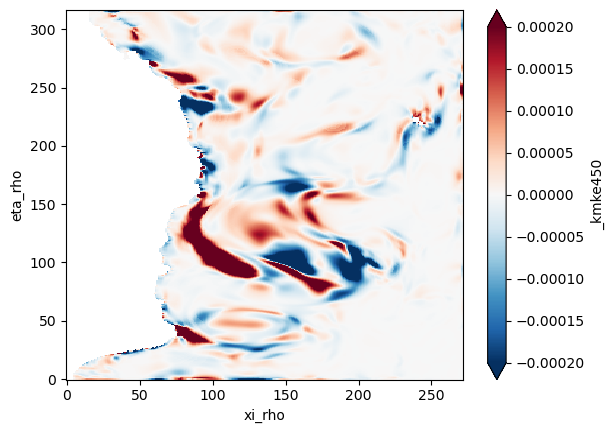

In [17]:
ds._kmke450.plot(vmin=-.0002,vmax=.0002,cmap='RdBu_r')

In [18]:
def rho_eos(Tt,Ts,z_r):
    #     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # %
    # % function [rho,bvf]=rho_eos(Tt,Ts,z_r)
    # %
    # % Computes density via Equation Of State (EOS) for seawater.
    # % If so prescribed, non-linear EOS of Jackett and McDougall (1995)
    # % is used.
    # %
    # % Tt potential temperature [deg Celsius].
    # % Ts salinity [PSU].
    # % Tz pressure/depth, [depth in meters and negative].
    # %
    # % K0, K1 and K2 are the pressure polynomial coefficients for secant
    # % bulk modulus, so that
    # %
    # %               bulk = K0 - K1 * z + K2 * z**2 ;
    # %
    # % while rho1 is sea-water density [kg/m^3] at standard pressure
    # % of 1 Atm, so that the density anomaly at in-sity pressure is
    # %
    # %               rho = rho1 / (1 + z / bulk) - 1000
    # %
    # %  Reference:
    # %
    # %  Jackett, D. R. and T. J. McDougall, 1995, Minimal Adjustment of
    # %  Hydrostatic Profiles to Achieve Static Stability, Journ of Atmos.
    # %  and Oceanic Techn., vol. 12, pp. 381-389.
    # %
    # % << This equation of state formulation has been derived by Jackett
    # %    and McDougall (1992), unpublished manuscript, CSIRO, Australia.
    # %    It computes in-situ density anomaly as a function of potential
    # %    temperature (Celsius) relative to the surface, salinity (PSU),
    # %    and depth (meters).  It assumes  no  pressure  variation along
    # %    geopotential  surfaces,  that  is,  depth  and  pressure  are
    # %    interchangeable. >>
    # %                                          John Wilkin, 29 July 92
    # %
    # % Check Values: T=3 C S=35.5 PSU Z=-5000 m rho=1050.3639165364 
    
    import numpy as np
    
    A00=+19092.56;A01=+209.8925;
    A02=-3.041638;A03=-1.852732e-3;A04=-1.361629e-5;A10=104.4077;
    A11=-6.500517;A12=+0.1553190;A13=2.326469e-4;AS0=-5.587545;
    AS1=+0.7390729;AS2=-1.909078e-2;B00=+4.721788e-1;B01=+1.028859e-2;
    B02=-2.512549e-4;B03=-5.939910e-7;B10=-1.571896e-2;B11=-2.598241e-4;
    B12=+7.267926e-6;BS1=+2.042967e-3;E00=+1.045941e-5;E01=-5.782165e-10;
    E02=+1.296821e-7;E10=-2.595994e-7;E11=-1.248266e-9;E12=-3.508914e-9;

    QR=+999.842594;Q01=+6.793952e-2;Q02=-9.095290e-3;
    Q03=+1.001685e-4;Q04=-1.120083e-6;Q05=+6.536332e-9;Q10=+0.824493;
    Q11=-4.08990e-3;Q12=+7.64380e-5;Q13=-8.24670e-7;Q14=+5.38750e-9;
    QS0=-5.72466e-3;QS1=+1.02270e-4;QS2=-1.65460e-6;Q20=+4.8314e-4;
    
    
    sqrtTs=np.sqrt(Ts);

    K0=A00+Tt*(A01+Tt*(A02+Tt*(A03+Tt*A04)))+Ts*(A10+Tt*(A11+Tt*(A12+Tt*A13))+sqrtTs*(AS0+Tt*(AS1+Tt*AS2)));
    K1=B00+Tt*(B01+Tt*(B02+Tt*B03))+Ts*(B10+Tt*(B11+Tt*B12)+sqrtTs*BS1);
    K2=E00+Tt*(E01+Tt*E02)+Ts*(E10+Tt*(E11+Tt*E12));
    rho1=QR+Tt*(Q01+Tt*(Q02+Tt*(Q03+Tt*(Q04+Tt*Q05))))+Ts*(Q10+Tt*(Q11+Tt*(Q12+Tt*(Q13+Tt*Q14)))+sqrtTs*(QS0+Tt*(QS1+Tt*QS2))+Ts*Q20);
    rho=rho1/(1+0.1*z_r/(K0-z_r*(K1-z_r*K2)));
    
    return rho

def calc_rho_ROMS(input):
    print('calculate density with custom rho_eos function')
    rho = rho_eos(input.temp,input.salt,input.z_rho)
    input["rho"] = rho
    return input

def calc_PeKe(input):
    
    g = 9.81
    print('calculate density with custom rho_eos function')
    rho = rho_eos(input.temp,input.salt,input.z_rho)
    print('save rho into ds')          
    input["rho"] = rho # write to ds so we can use the mean function
    input = input.drop_vars(['temp','salt','z_rho'])
     # calculate time-means
    print('calc time means')
    rho_bar = input.rho.mean(dim='ocean_time')
    w_bar = input.w.mean(dim='ocean_time')
     # calculate primes
    print('calc primes')
    w_prime = input.w - w_bar
    rho_prime = input.rho - rho_bar
    input = input.drop_vars(['w','rho'])
    w_prime_rho = grid.interp(w_prime,axis="Z",boundary="fill")
    # plt.figure()
    # w_prime_rho.mean(dim=['ocean_time','s_rho']).plot()
    # plt.show()
    # plt.figure()
    # rho_prime.mean(dim=['ocean_time','s_rho']).plot()
    # plt.show()
    PeKe = -g*rho_prime*w_prime_rho
    return PeKe



In [19]:
ds["peke"] = calc_PeKe(ds)
ds=ds.drop_vars(['w','salt','temp','rho'])

calculate density with custom rho_eos function
save rho into ds
calc time means
calc primes


In [20]:
ds["_peke450"] =grid.average(ds.peke.where(ds.z_rho0>-450),'Z').mean(dim='ocean_time')


<Figure size 640x480 with 0 Axes>

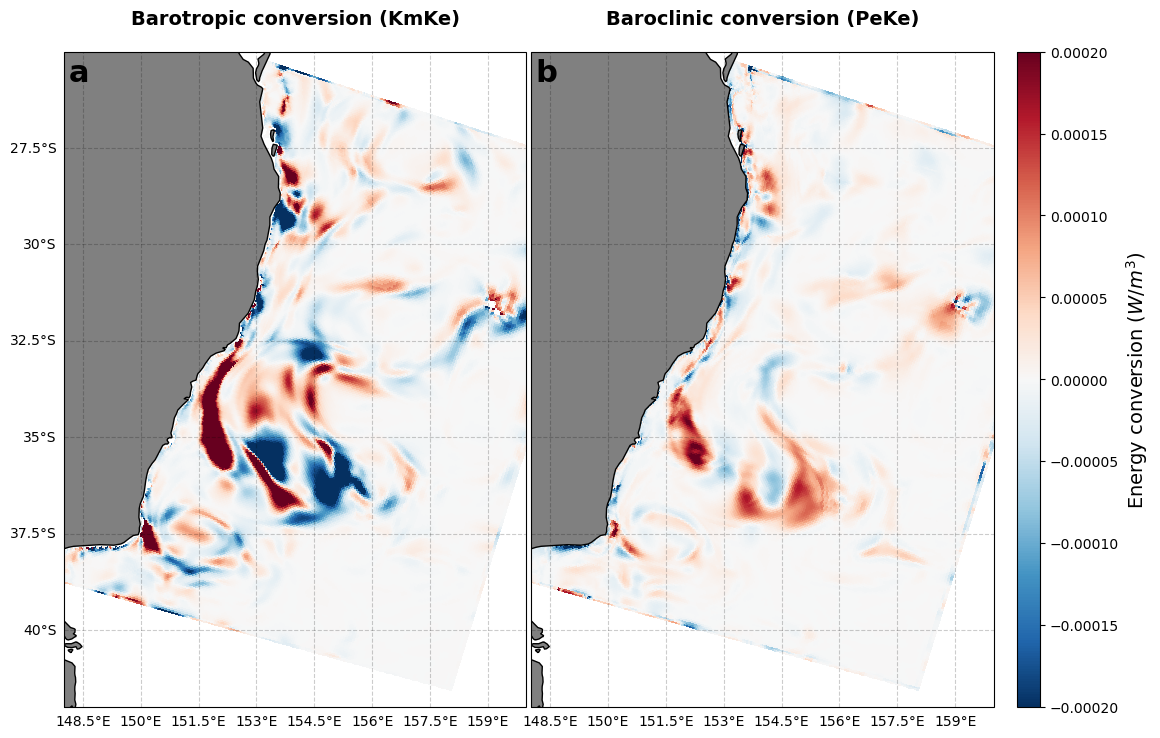

In [21]:


gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.01, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12,9])
ax = None


ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = ds._kmke450.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.0002,vmax=.0002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# gl.bottom_labels = False
ax.text(0.5, 1.05, 'Barotropic conversion (KmKe)',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')



ax = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = ds._peke450.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.0002,vmax=.0002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# gl.bottom_labels = False
ax.text(0.5, 1.05, 'Baroclinic conversion (PeKe)',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.00, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Energy conversion ($W/m^3$)',fontsize=14)